# Figure 2: Random sampling on 8 canonical Jigo Data with 24 data points each

copied from figure 4 of manuscript 1

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"  
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v1

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Display the four canonical phenotype Contrast Sensitivity Function (CSF) curves used to construct the generative models of Experiment 1. For each phenotype, train a GP from randomly sampled points labeled according to the generative model for that phenotype.

## References

Kalloniatis, Michael, and Charles Luu. “Visual Acuity.” In _Webvision: The Organization of the Retina and Visual System_, edited by Helga Kolb, Eduardo Fernandez, and Ralph Nelson. Salt Lake City (UT): University of Utah Health Sciences Center, 1995. http://www.ncbi.nlm.nih.gov/books/NBK11509/.


In [1]:
# Import libraries

import sys
import os

import torch as pt
import gpytorch as gp

import numpy as np

import json
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io # JIGO

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utility.utils import *

In [2]:
print("python version -->>", sys.version)
print("pytorch version -->>", pt.__version__)
print("gpytorch version -->>", gp.__version__)

python version -->> 3.10.4 (v3.10.4:9d38120e33, Mar 23 2022, 17:29:05) [Clang 13.0.0 (clang-1300.0.29.30)]
pytorch version -->> 2.0.0
gpytorch version -->> 1.10


This code was written for

- python version 3.10.9
- pytorch version 1.13.1
- gpytorch version 1.8.1

In [3]:
# JIGO
# 10 parameters of the data
DUMMY = 0 # 1, 2, 3… 10378
TILT = 1 # 1, -1
CUES = 2 # 1, 0
ECC = 3 # 0, 3, 6, 12
LOC = 4 # 1, -1
SF = 5 # 0.5, 1, 2, 4, 8, 11
CS = 6 # (0, 1], with NaN
ACC = 7 # 0, 1, NaN
TRIALIDX = 8 # 0, 1
CONDITION = 9 # 0

names = ['AB', 'AF', 'AS', 'LH', 'LS', 'MJ', 'RF', 'SC', 'SX']
sfs = [0.5, 1, 2, 4, 8, 11]
cues = [0, 1]
eccs = [0, 3, 6, 12]

In [4]:
# Run-time flags

verb_mode = True           # print verbose analyses?
scrn_mode = True           # plot on screen?
save_mode = True           # save plots in indicated directory?

plot_canon = True          # plot canonical CSF spline-interpolated curves?
plot_prior  = True         # plot GP posterior mean as prior?
plot_thresh  = True        # plot 50% threshold curve of prior?

In [5]:
# Constant declarations

# Fix random seed
generative_random_seed = 1

# evaluation grid bounds in raw linear units
# raw_freq_min = 1         # cycles per degree
# raw_freq_max = 64        # cycles per degree
raw_freq_min = 0.5
raw_freq_max = 16 # JIGO
raw_contrast_min = 1e-3  # contrast
raw_contrast_max = 1     # contrast

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04  # lapse rate is 4%
psi_sigma = .08
sigmoid_type = 'logistic'

# training parameters?
num_halton_points = 8
num_initial_points_training_iters = 500
num_new_points = 16
num_new_points_training_iters = 150

# GP hyperparameters?
lr = .125
beta_for_regularization = 0.25
gaussian_lengthscale = None
min_lengthscale = .15 

# other
# prior_raw_freq_min = 0.5
# prior_raw_freq_max = 64
prior_raw_freq_min = 0.125
prior_raw_freq_max = 32 # JIGO
prior_raw_contrast_min = 1e-3
prior_raw_contrast_max = 1

random_seed = 1


# define ghost points (they will have a label of 0, i.e., a color of red)
# JIGO
# raw_freq_ghost_points = [1, 2, 4, 8, 16, 32, 64, 128]
# raw_contrast_ghost_points = [5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1]
raw_freq_ghost_points = [0.5, 1, 2, 4, 8, 16, 32, 64]
raw_contrast_ghost_points = [5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1]

# other params to train_and_sample_gp method
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_entropy = True
calculate_posterior = True

markerwidth = .8
marker_size = 60
success_marker = '+' 
diamond_size = 1.0
diamond_width = .076            # specified in cycles per degree
diamond_height = .10            # specified in log10(contrast)
success_color = 'blue'
failure_color = 'red'
latent_color = '#cf30cf'
mean_color = '#40E1D0'
diamond_fill_color = 'None'
success_label = 'success'
failure_label = 'failure'

rmse_filename = 'rmses'

plot_points = True

cax_location_params = [0.84, 0.1, 0.02, 0.8] # [left, bottom, width, height]

subplots_adjust_params = {
    'bottom':0.1, 
    'top':0.9, 
    'left':0.1, 
    'right':0.8, 
    'wspace':0.05, 
    'hspace':0.3
}

num_rows = 2
num_cols = 4

# JIGO
data_dir = 'data/Jigo_thresh_data/'
data_file_name = 'four_D_thresh.mat'
data_file_path = f'{data_dir}{data_file_name}'
mat_data = scipy.io.loadmat(data_file_path)
Jigo_4D_thresh = mat_data['cs']

def get_Jigo_thresh(name='LS', cue=0, ecc=0):
    name_idx = names.index(name)
    ecc_idx = int(ecc/3)
    if ecc_idx == 4:
        ecc_idx -= 1 # these three lines enable correct ecc_idx
    thresh = logContrast().forward(1/Jigo_4D_thresh[name_idx, cue, :, ecc_idx])
    freq = logFreq().forward(np.array(sfs))
    Jigo_thresh_points = np.vstack((freq, thresh)).T
    return Jigo_thresh_points

'''
phenotypes = [
    ('Normal', csf_curves_exp1['normal']),
    ('Mild Amblyopia', csf_curves_exp1['mild_amblyopia']),
    ('Cataracts', csf_curves_exp1['cataracts']),
    ('Multiple Sclerosis', csf_curves_exp1['multiple_sclerosis'])
]
'''

if verb_mode:
    print_training_iters = True
    print_training_hyperparameters = False
    progress_bar = False
else:
    print_training_iters = False
    print_training_hyperparameters = False
    progress_bar = False
    
cblab_loc = 'center'

axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out'
}

mean_module_name = 'constant_mean'

# end other

In [6]:
# Standard plotting parameters

# JIGO?
fig_width = 8     # inches
fig_height = 4  # inches

dpi_val = 600     # graphics resolution

plt.rcParams['font.family'] = 'Arial'

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 10
tick_font_weight = 'roman'
label_font_size = 12
label_font_weight = 'roman'
title_font_size = 14
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'

colors = sns.color_palette('colorblind', n_colors=12)  # colorblind friendly palette
col1=0; col2=1; col3=2; col4=4

# JIGO
x_tick_labels = [0.5, 1, 2, 4, 8, 16]
x_tick_values = logFreq().forward(np.array(x_tick_labels))
y_tick_labels = [1, 0.1, 0.01, 0.001]
y_tick_values = logContrast().forward(np.array(y_tick_labels))
cb_tick_labels = [0, 0.25, 0.5, 0.75, 1]
cb_tick_values = cb_tick_labels

cb_pad = 0.05  # move coloarbar xx units horizontally
cblab_pad = -53  # move colorbar label xx units horizontally

num_spline_vals = 750  # number of interpolated points in spline curves

colmap='gist_gray'

# Plotting order -- higher on top
success_zorder = 5
fail_zorder = 4
thresh_zorder = 3
canon_zorder = 2
posterior_zorder = 1

p_title = 'Human Contrast Sensitivity Phenotypes' # JIGO?
x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

save_dir = './analysis/figure_01/'
file_stem = 'Figure01_RandomSampling'

## Perform analysis

In [7]:
name = 'LS'
results = dict()

set_random_seed(random_seed)

# JIGO
curve_idx = 0
for cue in cues: 
    for ecc in eccs: 

        ###################
        # CONSTRUCT CURVE #
        ###################

        curve = get_Jigo_thresh(name, cue, ecc) # JIGO
        curve = np.array(curve)
        '''
        # prepare freqs - turn log10 to log2, and start from 0
        curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
        '''
        left, right, bottom, top = get_data_bounds(curve)

        cs = create_cubic_spline(curve)

        ###############
        # CREATE GRID #
        ###############

        # Transform these bounds - used to make grid
        x_min = logFreq().forward(raw_freq_min)
        x_max = logFreq().forward(raw_freq_max)
        y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
        y_max = logContrast().forward(raw_contrast_min)

        # Make grid
        grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, \
                                                                x_resolution, y_resolution)

        #################
        # GENERATE DATA #
        #################

        # define how to transform the data
        prior_freq_min = logFreq().forward(prior_raw_freq_min)
        prior_freq_max = logFreq().forward(prior_raw_freq_max)
        prior_contrast_min = logContrast().forward(prior_raw_contrast_max) # 1/x swaps min and max
        prior_contrast_max = logContrast().forward(prior_raw_contrast_min)
        
        def f(d):
            return scale_data_within_range(d, (0, 1), prior_freq_min, \
                                        prior_freq_max, prior_contrast_min, prior_contrast_max)

        # create ghost points
        ghost_x1 = logFreq().forward(np.array(raw_freq_ghost_points))
        ghost_x2 = logContrast().forward(np.array(raw_contrast_ghost_points))
        
        assert len(ghost_x1) == len(ghost_x2), "make sure that the ghost arrays have the same length"

        ghost_X = np.vstack((ghost_x1, ghost_x2)).T
        ghost_y = np.array([0]*len(ghost_x2))

        num_ghost_points = len(ghost_y)

        # create initial data points
        halton_X, halton_y = halton_samples_from_data(xx, yy, cs, \
            psi_gamma, psi_lambda, num_halton_points, sigmoid_type = sigmoid_type, psi_sigma = psi_sigma)

        initial_Xs = np.vstack((ghost_X, halton_X))
        initial_ys = np.hstack((ghost_y, halton_y))

        num_initial_points = len(initial_ys) 

        # transform the data
        def f(d):
            return scale_data_within_range(d, (0, 1), x_min, x_max, y_min, y_max)

        #####################
        # INIT AND TRAIN GP #
        #####################
        
        model, likelihood, X, y, rmse_list, posterior_list, _ = sample_and_train_gp(
            cs,
            grid,
            xx,
            yy,
            sampling_strategy='random',
            mean_module_name=mean_module_name,
            psi_sigma=psi_sigma,
            sigmoid_type=sigmoid_type,
            psi_gamma=psi_gamma,
            psi_lambda=psi_lambda,
            lr=lr,
            num_initial_training_iters=num_initial_points_training_iters,
            num_new_points_training_iters=num_new_points_training_iters,
            num_new_points=num_new_points,
            beta_for_regularization=beta_for_regularization,
            train_on_all_points_after_sampling=train_on_all_points_after_sampling,
            phi=f,
            print_training_hyperparameters=print_training_hyperparameters,
            print_training_iters=print_training_iters,
            progress_bar=progress_bar,
            min_lengthscale=min_lengthscale,
            calculate_rmse=calculate_rmse,
            calculate_entropy=calculate_entropy,
            calculate_posterior=calculate_posterior,
            initial_Xs=initial_Xs,
            initial_ys=initial_ys,
            num_ghost_points=num_ghost_points
        )
        
        #################
        # EVALUATE GRID #
        #################

        # transform evaluation grid so it can be used by GP
        grid_transformed = transform_dataset(grid, phi=f)

        # get the predictions on the eval grid
        Z = evaluate_posterior_mean(model, likelihood, grid_transformed)
        zz = Z.reshape(xx.shape)
        
    
        results[curve_idx] = { #JIGO
            'xx': xx,
            'yy': yy,
            'zz': zz,
            'X': X,
            'y': y,
            'left': left,
            'right': right,
            'top': top,
            'bottom': bottom,
            'cs': cs,
            'psi_sigma': psi_sigma,
            'sigmoid_type': sigmoid_type,
            'psi_gamma': psi_gamma,
            'psi_lambda': psi_lambda,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'xs': xs,
            'ys': ys,
            'initial_points': num_initial_points,
            'grid': grid,
            'model': model,
            'likelihood': likelihood,
            'f': f,
            'rmse': rmse_list,
            'posterior_list': posterior_list,
        }
        curve_idx += 1
        

iteration 1/24
iteration 2/24
iteration 3/24
iteration 4/24
iteration 5/24
iteration 6/24
iteration 7/24
iteration 8/24
iteration 9/24
iteration 10/24
iteration 11/24
iteration 12/24
iteration 13/24
iteration 14/24
iteration 15/24
iteration 16/24
iteration 17/24
iteration 18/24
iteration 19/24
iteration 20/24
iteration 21/24
iteration 22/24
iteration 23/24
iteration 24/24
iteration 1/24
iteration 2/24
iteration 3/24
iteration 4/24
iteration 5/24
iteration 6/24
iteration 7/24
iteration 8/24
iteration 9/24
iteration 10/24
iteration 11/24
iteration 12/24
iteration 13/24
iteration 14/24
iteration 15/24
iteration 16/24
iteration 17/24
iteration 18/24
iteration 19/24
iteration 20/24
iteration 21/24
iteration 22/24
iteration 23/24
iteration 24/24
iteration 1/24
iteration 2/24
iteration 3/24
iteration 4/24
iteration 5/24
iteration 6/24
iteration 7/24
iteration 8/24
iteration 9/24
iteration 10/24
iteration 11/24
iteration 12/24
iteration 13/24
iteration 14/24
iteration 15/24
iteration 16/24
ite

## Plot figure

cue=0 ecc=0: 0.2222235612415334
cue=0 ecc=3: 0.24912782632909483
cue=0 ecc=6: 0.36229685106565646
cue=0 ecc=12: 0.48210877558652077
cue=1 ecc=0: 0.2041532797986732
cue=1 ecc=3: 0.27672629442329705
cue=1 ecc=6: 0.25533837508108115
cue=1 ecc=12: 0.45984393895985254


<Figure size 640x480 with 0 Axes>

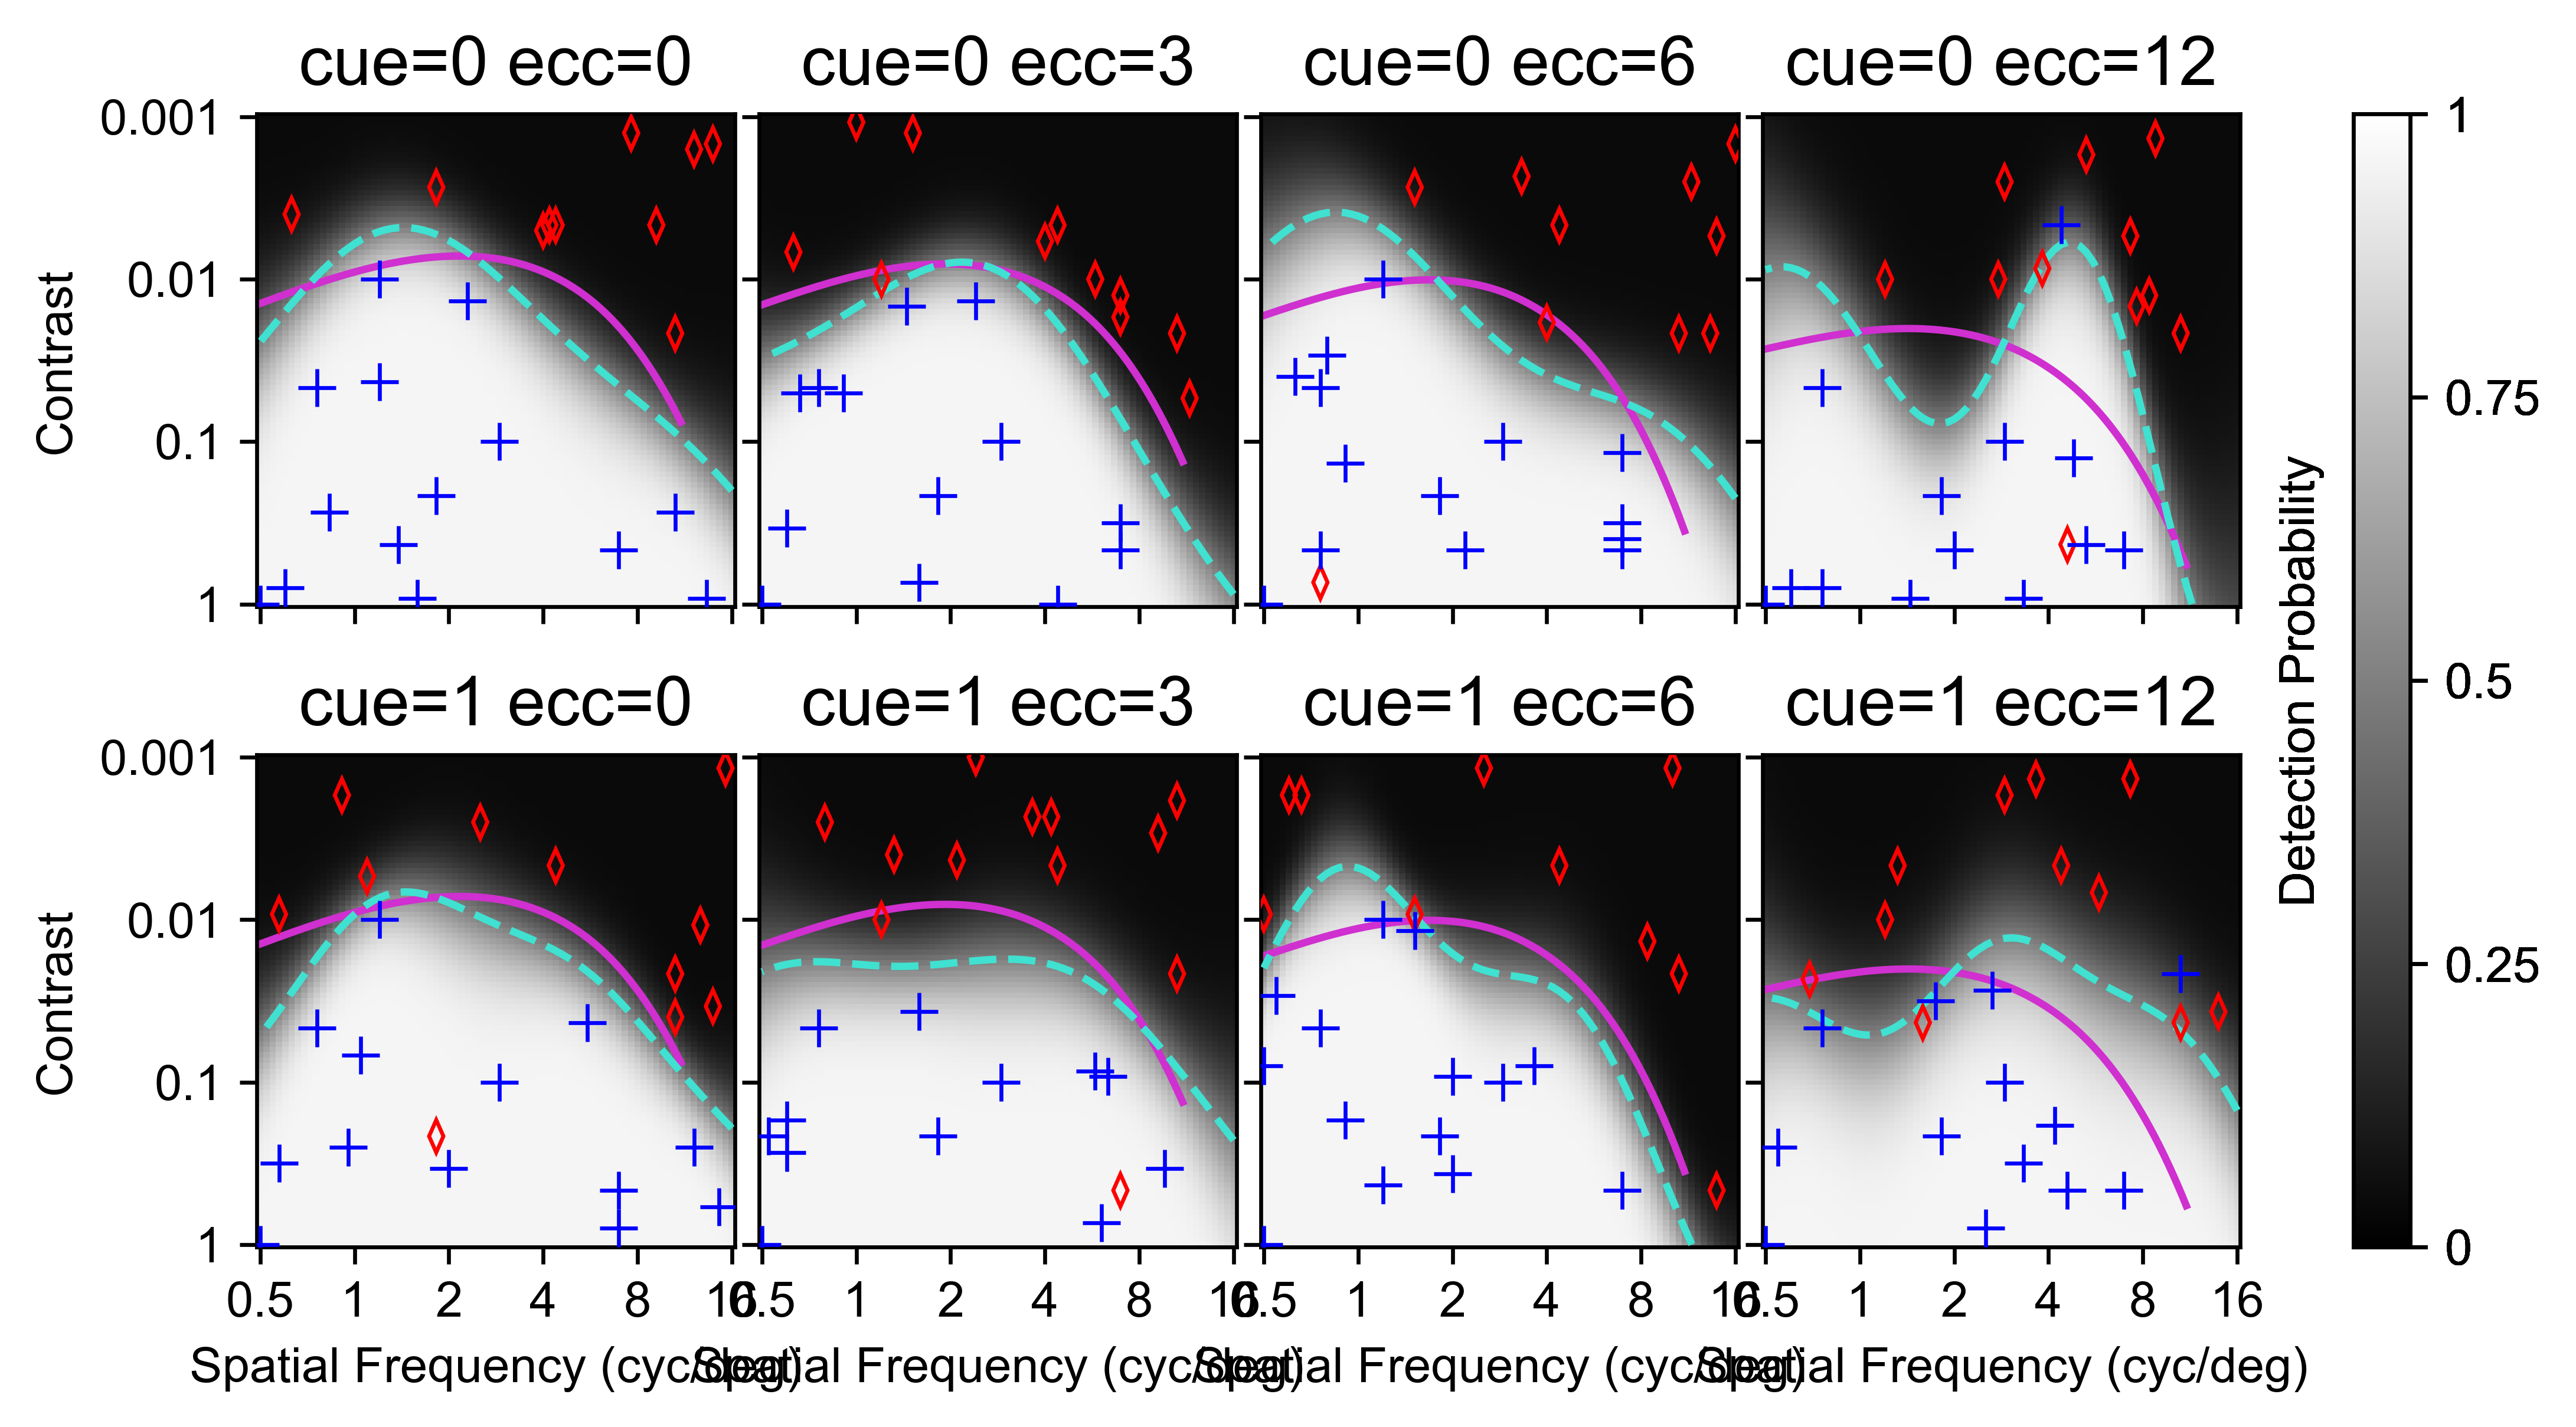

In [8]:
'''
The "results" dict has all of the information from the GP training.
'''

%matplotlib inline
plt.tight_layout()

# Set figure size # minor mistake?
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi_val)

# JIGO
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi_val)

rmse_values = []
    
# for i in range(len(phenotypes)):
# JIGO
curve_idx = 0
for cue in cues: 
    for ecc in eccs: 
    
        ax = axs[curve_idx // num_cols, curve_idx % num_cols]
        
        title = 'cue=' + str(cue) + ' ecc=' + str(ecc)

        pheno_results = results[curve_idx]
        
        xx = pheno_results['xx']
        yy = pheno_results['yy']
        zz = pheno_results['zz']
        X = pheno_results['X']
        y = pheno_results['y']
        left = pheno_results['left']
        right = pheno_results['right']
        top = pheno_results['top']
        bottom = pheno_results['bottom']
        cs = pheno_results['cs']
        psi_sigma = pheno_results['psi_sigma']
        psi_gamma = pheno_results['psi_gamma']
        psi_lambda = pheno_results['psi_lambda']
        x_min = pheno_results['x_min']
        x_max = pheno_results['x_max']
        y_min = pheno_results['y_min']
        y_max = pheno_results['y_max']
        xs = pheno_results['xs']
        ys = pheno_results['ys']
        initial_points = pheno_results['initial_points']
        grid = pheno_results['grid']
        f = pheno_results['f']
        posterior_list = pheno_results['posterior_list']
        rmse_list = pheno_results['rmse']
        
        print(f'{title}:', rmse_list[-1])
        rmse = rmse_list[-1]
        
        rmse_values.append(f'{title}: ' + str(rmse_list[-1]))
        
        ############
        # PLOTTING #
        ############

        # plot the contour field
        if plot_prior:
            mesh = ax.pcolormesh(xx, yy, zz, cmap=colmap, vmin=0, vmax=1, zorder=posterior_zorder)
            cax = fig.add_axes(cax_location_params)
            cbar = fig.colorbar(mesh, cax=cax, ticks=cb_tick_values, format='%g')
            cbar.set_label(cb_label, loc=cblab_loc, labelpad=cblab_pad)

        if plot_points:
            x1_failure = X[y == 0, 0].reshape(-1)
            x2_failure = X[y == 0, 1].reshape(-1)
            x1_success = X[y == 1, 0].reshape(-1)
            x2_success = X[y == 1, 1].reshape(-1)

            # Create diamond corner array
            diamond_corners = np.array([
                                    [x1_failure, x2_failure + diamond_height*diamond_size],
                                    [x1_failure + diamond_width*diamond_size, x2_failure],
                                    [x1_failure, x2_failure - diamond_height*diamond_size],
                                    [x1_failure - diamond_width*diamond_size, x2_failure]])
            ax.scatter(x1_success, x2_success, marker =success_marker, s=marker_size, color=success_color,
                        zorder=success_zorder, linewidth=markerwidth, label=success_label)
            ax.fill(diamond_corners[:, 0], diamond_corners[:, 1], color= diamond_fill_color, \
                    edgecolor=failure_color, 
                    zorder= fail_zorder, linewidth=markerwidth, label = failure_label)
    
        # plot the spline
        if plot_canon:
            latent_x1 = np.linspace(left, right, num_spline_vals)
            latent_x2 = cs(latent_x1)
            ax.plot(latent_x1, latent_x2, color=latent_color, zorder=canon_zorder)

        # plot the level curve
        if plot_thresh:
            level = (1 - psi_lambda + psi_gamma) / 2
            ax.contour(xx, yy, zz, levels=[level], colors=[mean_color], \
                    linestyles=['dashed'], zorder=thresh_zorder)
        
        ax.set_title(title, fontdict={'fontsize': title_font_size})
        
        # lims
        x_padding = (x_max - x_min) / (2 * (xs - 1))
        y_padding = (y_max - y_min) / (2 * (ys - 1))
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        
        curve_idx += 1 # JIGO
    
# set ticks and title
plt.setp(axs, xticks=x_tick_values, xticklabels=x_tick_labels, yticks=y_tick_values, yticklabels=y_tick_labels)

for ax in axs.flat:
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.label_outer() # only include across left and bottom
    ax.tick_params(**axis_tick_params, labelsize=tick_font_size)

# adjust and create colorbar
fig.subplots_adjust(**subplots_adjust_params)

if save_mode:
    ensure_directory_exists(save_dir)
    plt.savefig(f'{save_dir}{file_stem}.png', bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f'{save_dir}{file_stem}.pdf', bbox_inches='tight', dpi=dpi_val)
    with open(f'{save_dir}{rmse_filename}.txt', 'w') as file:
        for string in rmse_values:
            file.write(string + '\n')
            
if scrn_mode:
    plt.show()
else:
    plt.clf()